# Statistical Estimation for Physics : Bayesian Statistical Inference


Boris Bolliet (DAMTP)


Prerequisites:

- Bayes' theorem
- Central limit theorem 
- Estimators, bias, moments, least squares, maximum likelihood


In this notebook we will: 

- Use bayes' theorem for statistical inference
- work with concept of posterior, prior and likelihood 
- develop and illustrative example for parameter estimation, based on the CMB


Some References on this topic include: 

- F. James, Statistical Methods in Experimental Physics, Second Edition, WS, 2006
- A. Heavens, ICIC Data Analysis Workshop (private communication)
- R. Trotta, Bayesian Methods in Cosmology (eprint:1701.01467)
- S. Dodelson and F. Schmidt, Modern Cosmology, Second Edition, AP, 2020
- G. Cowan, Statistical Data Analysis, Oxford, 1998
- D. Hogg, J. Bovy & D. Lang, Data analysis recipes: Fitting a model to data (eprint:1008.4686)
- E. T. Jaynes, Probability Theory, The Logic of Science, CUP, 2003
- Hobson et al, Bayesian Methods in Cosmology, CUP, 2009
- T. Loredo, Bayesian Inference for the Physical Sciences (online)
- R. Cousins, Why isn’t every physicist a Bayesian?, 1994
- D. MacKay, Information Theory, Inference and Learning Algorithms, CUP, 2003 


# Import necessary packages

In [1]:
import pyactlike
from getdist import loadMCSamples, MCSamples
from getdist import plots
import scipy
import os
import yaml
import subprocess
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from classy_sz import Class
%matplotlib inline
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
current_path = os.getcwd()
print('notebook path:',current_path)
root_path = current_path +'/data'
os.chdir(root_path)
try:
    os.mkdir("chains")
except FileExistsError:
    print(">> chain directory already exists")
path_to_chains_dir = root_path + '/chains/'

print(path_to_chains_dir)


from matplotlib.ticker import LinearLocator
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
font = {'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

2023-11-22 21:59:51.312155: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-22 21:59:51.312180: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-22 21:59:51.312182: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-22 21:59:51.312210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-22 21:59:51.312223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


notebook path: /Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference
>> chain directory already exists
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/


# Collect ACT CMB data and likelihood

The act likelihood can be found at:

https://github.com/ACTCollaboration/pyactlike (credit: Zack Li)


## Collect best-fit CMB spectrum

In [2]:
#load the act likelihood
like = pyactlike.ACTPowerSpectrumData()

# Read an the spectrum from disk.
filename_wa = like.data_dir + "bf_ACTPol_lcdm.minimum.theory_cl"
tt_lmax = 5000

# collect the best-fit spectrum
ell, dell_tt, dell_te, dell_ee = np.genfromtxt(
    filename_wa,
    delimiter=None,
    unpack=True,
    max_rows=tt_lmax - 1,
    usecols=(0, 1, 2, 3),
)

## Test a calculation of the ACT likelihood on this

Here we evaluate the CMB likelihood for the best-fit spectra loaded above.

We only use the TT spectra in this notebook. 

In [3]:
%%time
like = pyactlike.ACTPowerSpectrumData(use_tt=True,use_te=False,use_ee=False)

chi2 = -2 * like.loglike(dell_tt, dell_te, dell_ee, 1.0)
print("ACT model chi2 = " + "{0:.2f}".format(chi2)+ " for 260 data points")

ACT model chi2 = 95.49 for 260 data points
CPU times: user 617 ms, sys: 1.97 s, total: 2.59 s
Wall time: 320 ms


## Plotting the CMB covariance matrix

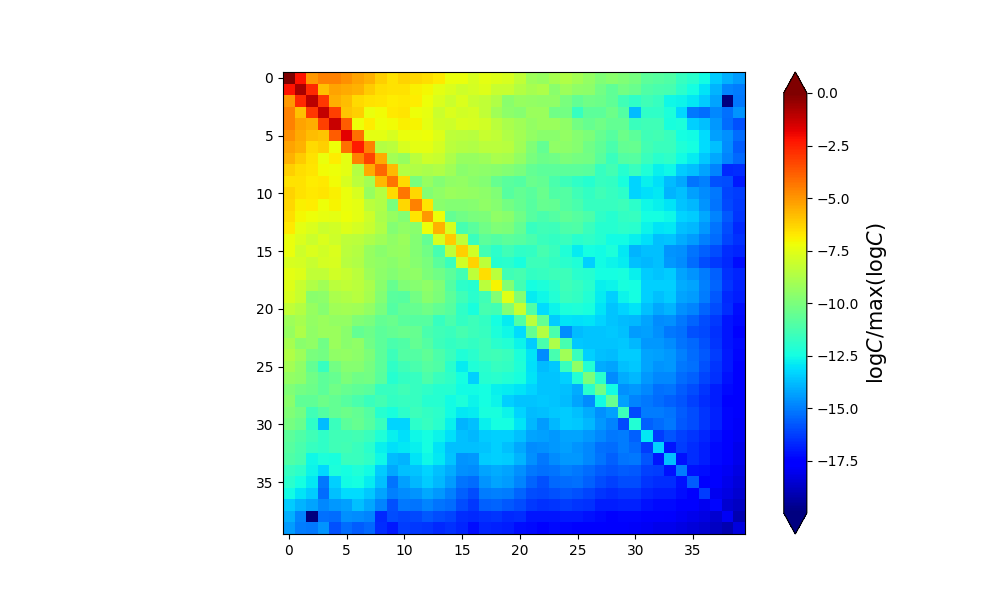

In [4]:

fig = plt.figure(figsize=(10,6))
my_cov = like.cov_tt.copy()[:40,:40]
my_cov = np.abs(my_cov)/np.abs(my_cov).max()
# my_cov[np.abs(my_cov)<1e-4] = 1e-4
myim = plt.imshow(np.log(my_cov),cmap='jet')
cbar = plt.colorbar(myim,extend='both')
cbar.set_label(r"$\mathrm{log} C/\mathrm{max}(\mathrm{log} C)$",size=15)
plt.savefig(current_path+'/figures/actlogabscov.pdf')
plt.savefig(current_path+'/figures/actlogabscov.png',dpi=300)

## Plotting the CMB data alone

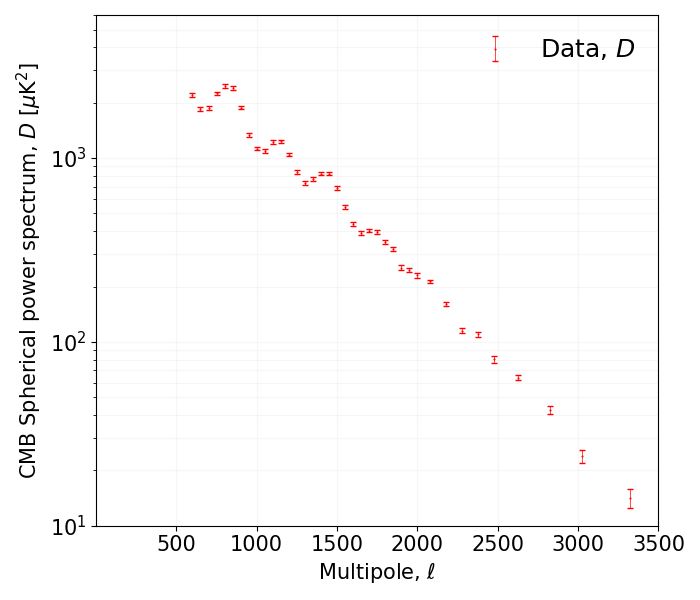

In [5]:

wmin=130  #first element of TT for wide patch
wmax=130+40 #last element of TT for wide patch
                                                      
TT_bval=like.bval[wmin:wmax]
TT_dat=like.X_data[wmin:wmax]*like.bval[wmin:wmax]**2/(2.*np.pi)
TT_err=like.X_sig[wmin:wmax]*like.bval[wmin:wmax]**2/(2.*np.pi)

fig = plt.figure(figsize=(7,6))

plt.errorbar(TT_bval,TT_dat,yerr = TT_err, marker='.',capsize=2,elinewidth=0.5,
         label=r"Data, $D$",markersize=1,ls='None',c='r')


plt.yscale('log')
plt.xlim(2,3500)
plt.ylim(1e1,6000)

plt.xlabel(r"Multipole, $\ell$",size=15)
plt.ylabel(r"CMB Spherical power spectrum, $ D$ $[\mu$K$^2]$",size=15)
plt.legend(frameon=False,fontsize = 18)
plt.grid(which='both',alpha=0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.tight_layout()
plt.savefig(current_path+"/figures/data_only.pdf")
plt.savefig(current_path+"/figures/data_only.png",dpi=300)

## Interactive plot

In [6]:

def compute_cls(age=13.8, m_nu=0.06):


    cosmo = Class()
    
    new_cosmo_params = {
    'm_ncdm' : m_nu,
    'age' : age,
    }
    cosmo.set(new_cosmo_params)
    
    cosmo.set({
    'output' : 'tCl',
    'ln10^{10}A_s' : 3.0460125,
    'n_s': 1.0107972,
    'omega_b' : 0.021519356,
    'omega_cdm' : 0.11681165,
    'tau_reio' : 0.063418096,
    'skip_background_and_thermo' : 0,
    'skip_pkl' : 1, # for this run we dont need this
    'skip_pknl' : 1, # for this run we dont need this
    'skip_hubble' : 1, # for this run we dont need this
    'skip_sigma8_and_der' : 1, # for this run we dont need this
    'skip_sigma8_at_z' : 1, # for this run we dont need this
    'skip_chi' : 1, # for this run we dont need this
    # settings for 1 massive neutrino and 2 massless states
    'cosmo_model' : 1,
    'N_ncdm' : 1,
    'N_ur'  : 2.0308,
    })
    cosmo.compute_class_szfast()
    
    lensed_cls = cosmo.lensed_cl()
    l_fast = lensed_cls['ell']
    cl_tt_fast = lensed_cls['tt']



    return cl_tt_fast

interactive(children=(FloatSlider(value=14.8, description='age', max=15.0, min=13.0, step=0.05), FloatSlider(v…

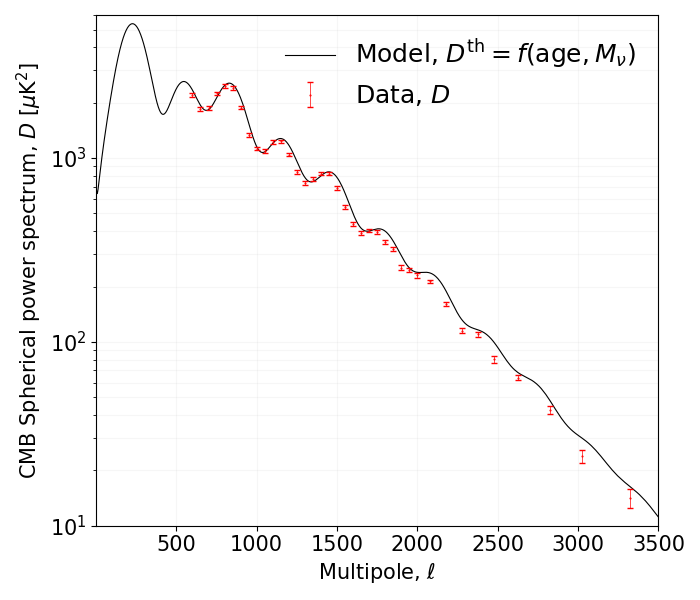

In [7]:
ls = np.arange(0,20000)
fig = plt.figure(figsize=(7,6))
line, = plt.plot(ls,ls*(ls+1)/2./np.pi*compute_cls(age=13.8,m_nu=0.06)*(2.7255e6)**2,
                 c='k',lw=0.8,label=r'Model, $D^\mathrm{th}=f(\mathrm{age},M_\nu)$')

plt.errorbar(TT_bval,TT_dat,yerr = TT_err, marker='.',capsize=2,elinewidth=0.5,
         label=r"Data, $D$",markersize=1,ls='None',c='r')

plt.yscale('log')
plt.xlim(2,3500)
plt.ylim(1e1,6000)
plt.xlabel(r"Multipole, $\ell$",size=15)
plt.ylabel(r"CMB Spherical power spectrum, $ D$ $[\mu$K$^2]$",size=15)
plt.legend(frameon=False,fontsize = 18)
plt.grid(which='both',alpha=0.1)
def update(age = 14.8, m_nu = 0.86):

    line.set_ydata(ls*(ls+1)/2./np.pi*compute_cls(age,m_nu)*(2.7255e6)**2)
    fig.canvas.draw_idle()
    
interact(update, age = (13.,15,0.05), m_nu = (0.,2.,0.01));
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig.tight_layout()
# plt.savefig("interactiv_plot.pdf")

# The 2-parameter case with wide uniform priors

Here we run an MCMC to estimate the posterior distribution $P(\mathrm{age},M_\nu|D)$

In [13]:
# load a template yaml to be slightly modified according to our needs
Dict_yaml = yaml.safe_load(open(path_to_chains_dir+'/pyactlike_age_H0_derived.yaml'))

In [14]:
Dict_yaml['output'] = path_to_chains_dir +'pyactlike_age'
Dict_yaml['sampler']['mcmc']['covmat'] = path_to_chains_dir+'../pyactlike_age_mnu.covmat'
Dict_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.01


Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1 # for this run we dont need this
# settings for 1 massive neutrino and 2 massless states
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['cosmo_model'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ncdm'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ur']  = 2.0308

with open(path_to_chains_dir+'pyactlike_system.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

## Run the chains with the mcmc method

In MCMC, we have to sample the parameter space and generate a theoretical power spectrum many times. Traditionally, this is done using Boltzmann theory codes such as CLASS ([code](https://github.com/lesgourg/class_public), [paper](https://arxiv.org/abs/1104.2932)) or CAMB ([code](https://github.com/cmbant/CAMB/), [paper](https://ui.adsabs.harvard.edu/abs/2000ApJ...538..473L/abstract)). In this notebook, we instead make use of emulators made with Cosmopower ([code](https://github.com/alessiospuriomancini/cosmopower), [paper](https://arxiv.org/abs/2106.03846)), a set of trained neural networks that significantly speeds up the computation of theory power spectra and parameter estimation. These specific emulators here are trained with Stage IV accuracy requirements, as reported [here](https://arxiv.org/abs/2303.01591).

Currently, the cosmopower emulators are wrapped within the class_sz ([code](https://github.com/CLASS-SZ/class_sz), [paper](https://inspirehep.net/literature/2715411)) code, which easily allows for exact evaluation of background and thermodynamics quantities while calling the cosmopower emulators to predict the CMB spectra.


To run the chains, execute:

```
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      path_to_chains_dir+'pyactlike_system.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)
```

The above should take a few minutes. Note that on a pedestrian "grid search" rather than MCMC, this would take many hours !

## Analyse the chains

Here we use Getdist for Kernel Density Estimation (KDE)

GetDist is made publicly available at https://github.com/cmbant/getdist (by the great Antony Lewis). 

In [4]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'pyactlike_age')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

i=0
readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.2})

Fs = readsamps.getInlineLatex('H0',limit=1)
print('H0: ',Fs)
Fs = readsamps.getInlineLatex('age',limit=1)
print('age: ',Fs)
Fs = readsamps.getInlineLatex('m_ncdm',limit=2)
print('m_ncdm: ',Fs)

readsamps.paramNames.parWithName('m_ncdm').label = r'M_\nu\,\,\mathrm{[eV]}'
readsamps.paramNames.parWithName('age').label = r'\mathrm{age}\,\,\mathrm{[Gyr]}'
samples = readsamps
samples.updateBaseStatistics()
all_samples.append(samples)

running getdist on chains /Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age


producing files in directory  ./
Removed 0.2 as burn in
using 4196 rows, 5 parameters; mean weight 3.0943755958055292, tot weight 12984.0
Approx indep samples (N/corr length): 1133
Equiv number of single samples (sum w)/max(w): 464
Effective number of weighted samples (sum w)^2/sum(w^2): 2475
Best fit sample -log(Like) = 48.943798
Ln(mean 1/like) = 50.896281
mean(-Ln(like)) = 49.834554
-Ln(mean like)  = 49.569724


producing files in directory  ./
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.3.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.2.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.1.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.4.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00629
RL: Thin for Markov:  28
RL: Thin for indep samples:   28
RL: Estimated burn in steps:  112  ( 36  rows)
using 4196 rows, 5 parameters; mean weight 3.0943755958055292, tot weight 12984.0
Approx indep samples (N/corr length): 1133
Equiv number of single samples (sum w)/max(w): 464
Effective number of weighted samples (sum w)^2/sum(w^2): 2475
Best fit sample -log(Like) = 48.943798


## Posterior and Bayesian Credible Intervals

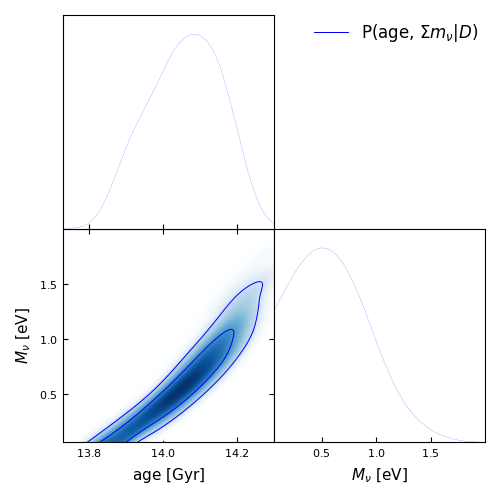

In [5]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 5

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False
g.settings.num_plot_contours = 2
g.settings.title_limit=0 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
    
g.triangle_plot(sample_list,
    [
    'age',
    'm_ncdm',
    ],

    filled=[False,False],
    shaded=True,
    legend_labels=[ r'P(age, $\Sigma m_\nu$|$D$)'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'0.1','color':'blue','ls':'-'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )

g.export(current_path +'/figures/actlite_TT_age_mnu.pdf')
plt.savefig(current_path +'/figures/actlite_TT_age_mnu.png',dpi=300)

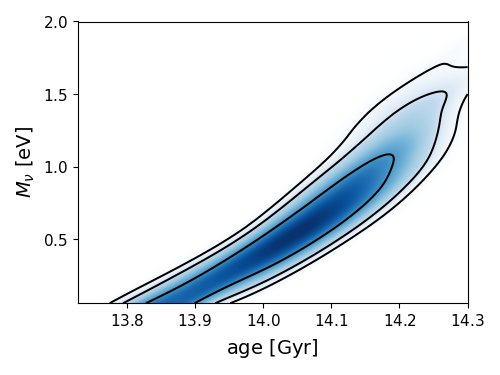

In [7]:
g = plots.get_single_plotter(width_inch=5)

g.settings.num_plot_contours = 10
g.plot_2d([sample_list[0]], 'age', 'm_ncdm', shaded=True,
          ls='None',
         );

g.export(current_path +'/figures/actlite_TT_age_mnu_2d_shaded.pdf')
plt.savefig(current_path +'/figures/actlite_TT_age_mnu_2d_shaded.png',dpi=300)

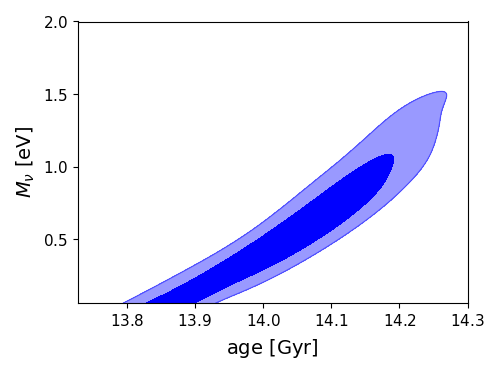

In [8]:
g = plots.get_single_plotter(width_inch=5)

g.settings.num_plot_contours = 2
g.plot_2d([sample_list[0]], 'age', 'm_ncdm', shaded=False,filled=True,
          ls='None',colors=['blue']
         );

g.export(current_path +'/figures/actlite_TT_age_mnu_2d_1_2s.pdf')
plt.savefig(current_path +'/figures/actlite_TT_age_mnu_2d_1_2s.png',dpi=300)

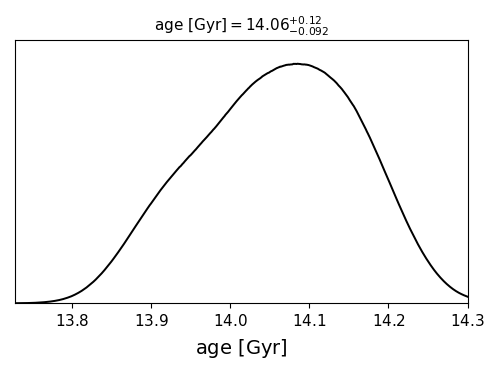

In [10]:
g = plots.get_single_plotter(width_inch=5)
g.settings.title_limit=1
g.plot_1d([sample_list[0]], 'age', shaded=True);
ax = g.subplots[0,0]

g.export(current_path+'/figures/actlite_TT_age_1d.pdf')
plt.savefig(current_path+'/figures/actlite_TT_age_mnu_1d.png',dpi=300)

# Case with a log-uniform on $M_\nu$

Keeping the same bounds, we swap the uniform prior for a log-uniform prior. As we will see this leads to a different posterior, certainly less motivated:
How would you justify using $\mathrm{log} M_\nu$ as your parameter?

Maybe you can, maybe not. But let's try anyways, just to apreciate that chosing a prior can be ambiguous.

Our lower bound:

In [11]:
np.log(0.06)

-2.8134107167600364

Our upper bound:

In [13]:
np.log(2.)

0.6931471805599453

In [15]:
Dict_yaml = yaml.safe_load(open(path_to_chains_dir+'pyactlike_age_logmnu_H0_derived.yaml'))

In [16]:
Dict_yaml['output'] = path_to_chains_dir +'pyactlike_logmnu'
Dict_yaml['sampler']['mcmc']['covmat'] = path_to_chains_dir+'../pyactlike_logmnu.covmat'
Dict_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.01

Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1 # for this run we dont need this
# settings for 1 massive neutrino and 2 massless states
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['cosmo_model'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ncdm'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ur']  = 2.0308



with open(path_to_chains_dir+'pyactlike_system_logmnu.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

Run the chains:

```
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      path_to_chains_dir+'pyactlike_system_logmnu.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

```

In [21]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'pyactlike_age')
path_to_chains.append(path_to_chains_dir)

final_chain_dir_list.append(path_to_chains_dir +'pyactlike_logmnu')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

for i in range(len(final_chain_dir_list)):
    readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.2})
    Fs = readsamps.getInlineLatex('H0',limit=1)
    print('H0: ',Fs)
    Fs = readsamps.getInlineLatex('age',limit=1)
    print('age: ',Fs)
    Fs = readsamps.getInlineLatex('m_ncdm',limit=2)
    print('m_ncdm: ',Fs)
    readsamps.paramNames.parWithName('m_ncdm').label = r'M_\nu\,\,\mathrm{[eV]}'
    readsamps.paramNames.parWithName('age').label = r'\mathrm{age}\,\,\mathrm{[Gyr]}'
    samples = readsamps
    samples.updateBaseStatistics()
    all_samples.append(samples)

running getdist on chains /Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age


producing files in directory  ./
Removed 0.2 as burn in
using 4196 rows, 5 parameters; mean weight 3.0943755958055292, tot weight 12984.0
Approx indep samples (N/corr length): 1133
Equiv number of single samples (sum w)/max(w): 464
Effective number of weighted samples (sum w)^2/sum(w^2): 2475
Best fit sample -log(Like) = 48.943798
Ln(mean 1/like) = 50.896281
mean(-Ln(like)) = 49.834554
-Ln(mean like)  = 49.569724


producing files in directory  ./
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.3.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.2.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.1.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.4.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00629
RL: Thin for Markov:  28
RL: Thin for indep samples:   28
RL: Estimated burn in steps:  112  ( 36  rows)
using 4196 rows, 5 parameters; mean weight 3.0943755958055292, tot weight 12984.0
Approx indep samples (N/corr length): 1133
Equiv number of single samples (sum w)/max(w): 464
Effective number of weighted samples (sum w)^2/sum(w^2): 2475
Best fit sample -log(Like) = 48.943798


producing files in directory  ./
Removed 0.2 as burn in
using 3116 rows, 6 parameters; mean weight 3.0937098844672657, tot weight 9640.0
Approx indep samples (N/corr length): 874
Equiv number of single samples (sum w)/max(w): 459
Effective number of weighted samples (sum w)^2/sum(w^2): 1832
Best fit sample -log(Like) = 49.535842
Ln(mean 1/like) = 50.878255
mean(-Ln(like)) = 50.278181
-Ln(mean like)  = 50.102811


producing files in directory  ./
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_logmnu.4.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_logmnu.2.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_logmnu.3.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_logmnu.1.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.01122
RL: Thin for Markov:  21
RL: Thin for indep samples:   21
RL: Estimated burn in steps:  63  ( 20  rows)
using 3116 rows, 6 parameters; mean weight 3.0937098844672657, tot weight 9640.0
Approx indep samples (N/corr length): 874
Equiv number of single samples (sum w)/max(w): 459
Effective number of weighted samples (sum w)^2/sum(w^2): 1832
Best fit sample -log(Like) = 4

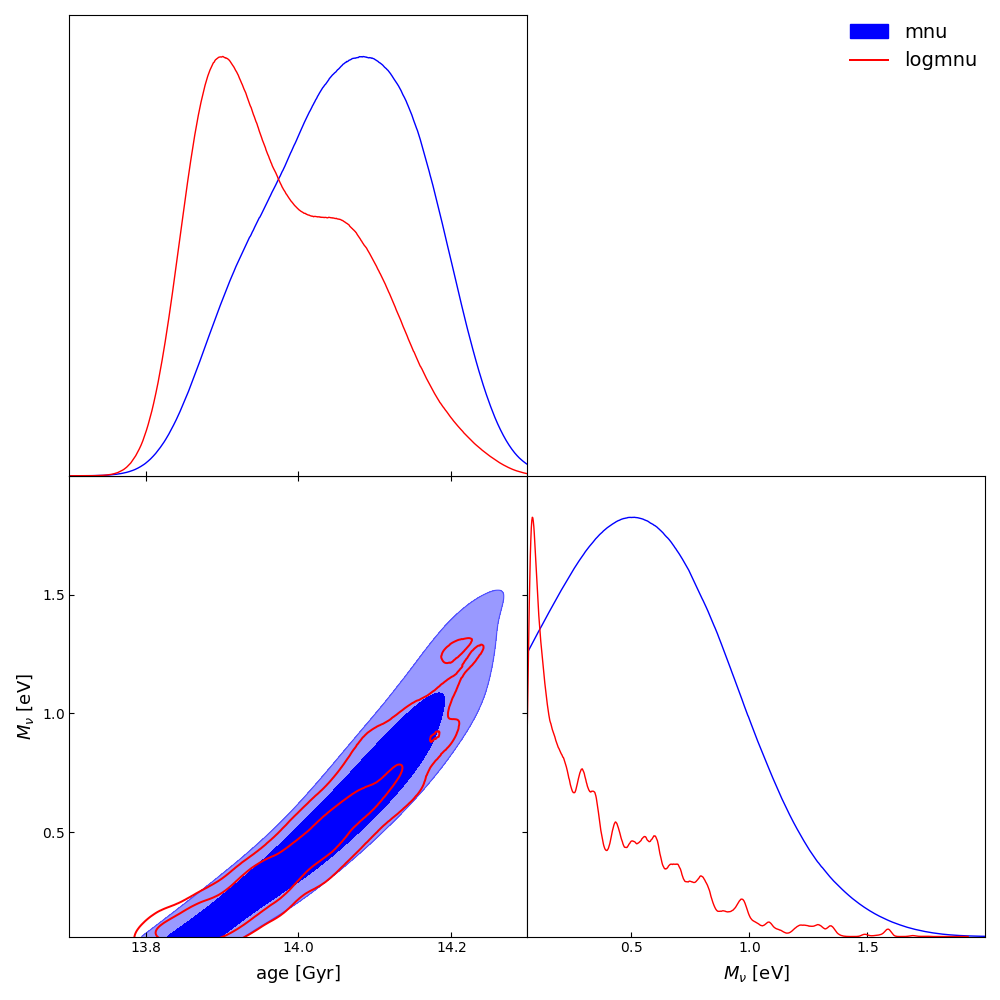

In [22]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 10

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=0 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
    
g.triangle_plot(sample_list,
    [
    'age',
    'm_ncdm',
    ],

    filled=[True,False],
    legend_labels=[ 'mnu','logmnu'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )

# Case with a tight constraint on $M_\nu$


we assume a new particle physics experiment has measured the masses of neutrinos, yielding:

\begin{equation}
M_\nu = 0.15 \pm 0.05 \,\,\mathrm{eV}
\end{equation}

How old is the universe then? 

In [45]:
Dict_yaml = yaml.safe_load(open(path_to_chains_dir+'pyactlike_age_H0_derived_mnu_prior.yaml'))

In [46]:
Dict_yaml['output'] = path_to_chains_dir +'pyactlike_age_mnu_prior'
Dict_yaml['sampler']['mcmc']['covmat'] = path_to_chains_dir+'../pyactlike_age_mnu_prior.covmat'
Dict_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.001 ## require slighly more converged result so we indeed recover the 68%CL at least as good as new Mnu measurement! 


Dict_yaml['theory'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['use_class_sz_fast_mode'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['stop_at_error'] = True
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args'] = {}
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['output'] = 'tCl'
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_background_and_thermo'] = 0
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pkl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_pknl'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_hubble'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_and_der'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_sigma8_at_z'] = 1 # for this run we dont need this
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['skip_chi'] = 1 # for this run we dont need this
# settings for 1 massive neutrino and 2 massless states
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['cosmo_model'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ncdm'] = 1
Dict_yaml['theory']['classy_szfast.classy_sz.classy_sz']['extra_args']['N_ur']  = 2.0308

with open(path_to_chains_dir+'pyactlike_system_mnu_prior.yaml', 'w') as outfile:
    yaml.dump(Dict_yaml, outfile, default_flow_style=False)

Run the chains:

```
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      path_to_chains_dir+'pyactlike_system_mnu_prior.yaml',
                      "-f"]
subprocess.call(str_cmd_subprocess)

```

In [47]:
path_to_chains_dir

'/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/'

In [56]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'pyactlike_age')
path_to_chains.append(path_to_chains_dir)

final_chain_dir_list.append(path_to_chains_dir +'pyactlike_age_mnu_prior')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.2"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

for i in range(len(final_chain_dir_list)):
    readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.2})
    Fs = readsamps.getInlineLatex('H0',limit=1)
    print('H0: ',Fs)
    Fs = readsamps.getInlineLatex('age',limit=1)
    print('age: ',Fs)
    Fs = readsamps.getInlineLatex('m_ncdm',limit=1)
    print('m_ncdm: ',Fs)
    readsamps.paramNames.parWithName('m_ncdm').label = r'M_\nu\,\,\mathrm{[eV]}'
    readsamps.paramNames.parWithName('age').label = r'\mathrm{age}\,\,\mathrm{[Gyr]}'
    samples = readsamps
    samples.updateBaseStatistics()
    all_samples.append(samples)

running getdist on chains /Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age


producing files in directory  ./
Removed 0.2 as burn in
using 4196 rows, 5 parameters; mean weight 3.0943755958055292, tot weight 12984.0
Approx indep samples (N/corr length): 1133
Equiv number of single samples (sum w)/max(w): 464
Effective number of weighted samples (sum w)^2/sum(w^2): 2475
Best fit sample -log(Like) = 48.943798
Ln(mean 1/like) = 50.896281
mean(-Ln(like)) = 49.834554
-Ln(mean like)  = 49.569724


producing files in directory  ./
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.3.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.2.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.1.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age.4.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00629
RL: Thin for Markov:  28
RL: Thin for indep samples:   28
RL: Estimated burn in steps:  112  ( 36  rows)
using 4196 rows, 5 parameters; mean weight 3.0943755958055292, tot weight 12984.0
Approx indep samples (N/corr length): 1133
Equiv number of single samples (sum w)/max(w): 464
Effective number of weighted samples (sum w)^2/sum(w^2): 2475
Best fit sample -log(Like) = 48.943798


producing files in directory  ./
Removed 0.2 as burn in
using 7982 rows, 7 parameters; mean weight 2.7047105988474067, tot weight 21589.0
Approx indep samples (N/corr length): 2726
Equiv number of single samples (sum w)/max(w): 771
Effective number of weighted samples (sum w)^2/sum(w^2): 4835
Best fit sample -log(Like) = 47.195867
Ln(mean 1/like) = 49.082044
mean(-Ln(like)) = 48.127496
-Ln(mean like)  = 47.857242


producing files in directory  ./
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age_mnu_prior.4.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age_mnu_prior.2.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age_mnu_prior.3.txt
/Users/boris/Documents/GitHub/Statistical_estimation_in_physics/bayesian_inference/data/chains/pyactlike_age_mnu_prior.1.txt
Removed 0.2 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00155
RL: Thin for Markov:  28
RL: Thin for indep samples:   28
RL: Estimated burn in steps:  84  ( 31  rows)
using 7982 rows, 7 parameters; mean weight 2.7047105988474067, tot weight 21589.0
Approx indep samples (N/corr length): 2726
Equiv number of single samples (sum w)/max(w): 771
Effective number of weighted samples (sum w)^2/sum(w^2): 4835


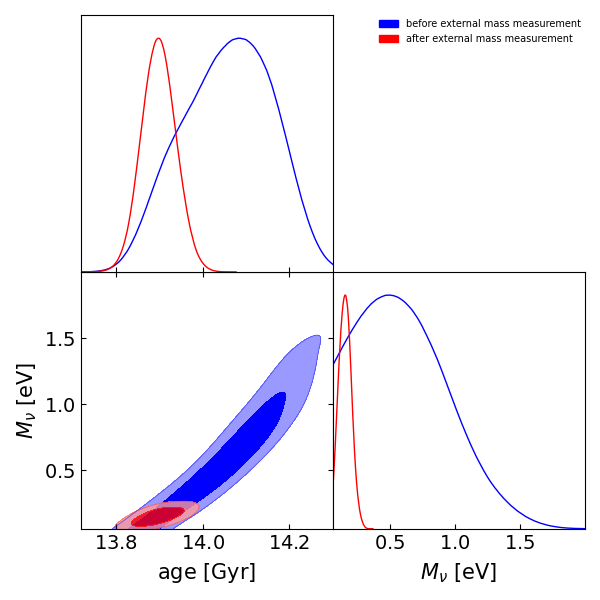

In [57]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 6

g.settings.axes_fontsize = 15
g.settings.lab_fontsize =16

g.settings.legend_fontsize = 8
g.settings.alpha_filled_add=0.8
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=0 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
g.triangle_plot(sample_list,
    [
    'age',
    'm_ncdm',
    ],

    filled=[True,True],
    legend_labels=[ 'before external mass measurement','after external mass measurement'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )

plt.savefig(current_path+'/figures/tri_actlite_TT_age_mnu_2d_1_2s_all.pdf')
plt.savefig(current_path+'/figures/tri_actlite_TT_age_mnu_2d_1_2s_all.png',dpi=300)

Here below we make a few variants of the plot for presentation

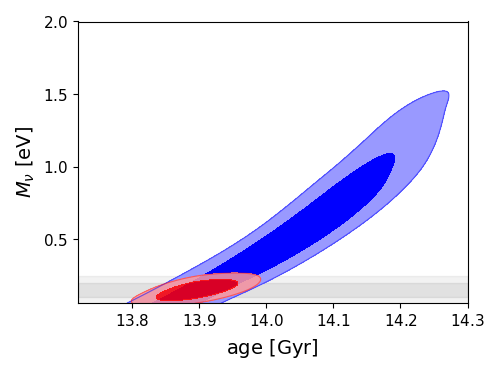

In [58]:
g = plots.get_single_plotter(width_inch=5)
g.add_y_bands(0.15, 0.05)
g.plot_2d([all_samples[0],
           all_samples[1]], 
          'age', 'm_ncdm', filled={True,True},colors=['blue','red']);

g.export(current_path+'/figures/actlite_TT_age_mnu_2d_1_2s_all.pdf')
plt.savefig(current_path+'/figures/actlite_TT_age_mnu_2d_1_2s_all.png',dpi=300)

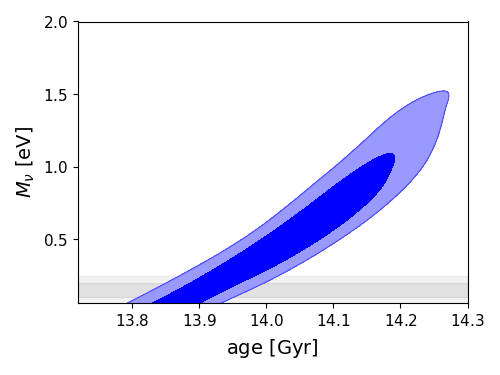

In [59]:
g = plots.get_single_plotter(width_inch=5)
g.add_y_bands(0.15, 0.05)
g.plot_2d([all_samples[0]],
          'age', 'm_ncdm', filled={True},colors=['blue']);

g.export(current_path+'figures/actlite_TT_age_mnu_mnu_prior_2d.pdf')
plt.savefig(current_path+'figures/actlite_TT_age_mnu_2d_1_2s_with_mnuprior.png',dpi=300)

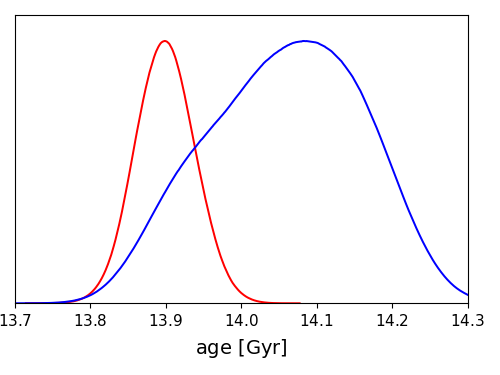

In [60]:
g = plots.get_single_plotter(width_inch=5)
g.settings.title_limit=0
g.plot_1d([all_samples[1],all_samples[0]], 'age', shaded=True,colors=['red','blue']);
ax = g.subplots[0,0]
ax.set_xlim(13.7,14.3)
g.export(current_path +'figures/actlite_TT_age_1d_mnu_prior.pdf')
plt.savefig(current_path +'figures/actlite_TT_age_1d_mnu_prior.png',dpi=300)

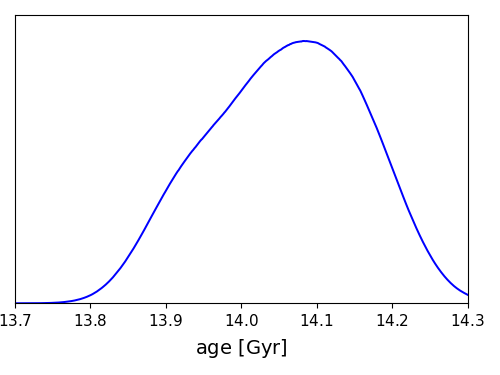

In [61]:
g = plots.get_single_plotter(width_inch=5)
g.settings.title_limit=0
g.plot_1d([all_samples[1],all_samples[0]], 'age', shaded=True,colors=['red','blue'],ls=['None','-']);
ax = g.subplots[0,0]
ax.set_xlim(13.7,14.3)
g.export(current_path +'figures/actlite_TT_age_1d_no_mnu_prior.pdf')
plt.savefig(current_path +'figures/actlite_TT_age_1d_no_mnu_prior.png',dpi=300)

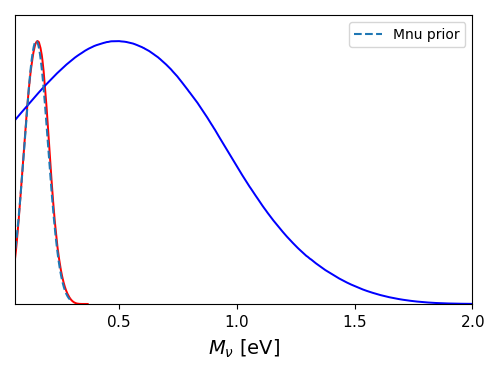

In [66]:
g = plots.get_single_plotter(width_inch=5)
g.settings.title_limit=0
g.plot_1d([all_samples[1],all_samples[0]], 'm_ncdm', shaded=True,colors=['red','blue'],ls=['-','-']);
ax = g.subplots[0,0]
# ax.set_xlim(13.7,14.3)
mean = 0.15
std_dev = 0.05
max_amplitude = 1

# Generate data
x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 1000)
y = max_amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))
ax.plot(x,y,label='Mnu prior',ls='--')
plt.legend()
g.export(current_path +'figures/actlite_TT_age_1d_no_age_mnuprior.pdf')
plt.savefig(current_path +'figures/actlite_TT_age_1d_no_age_mnuprior.png',dpi=300)

# Computing the CMB likelihood

## Likelihood of Mnu

In [674]:
%%time


np_mnu = 100
mnu = np.linspace(0.,0.3,np_mnu)
chi2s_mnu = []
for a in mnu:
    dell_tt_th = (ls*(ls+1)/2./np.pi*compute_cls(age=13.8,m_nu=a)*(2.7255e6)**2)[2:5001]

    like = pyactlike.ACTPowerSpectrumData(use_tt=True,use_te=False,use_ee=False)

    chi2s_mnu.append(-2 * like.loglike(dell_tt_th, dell_te, dell_ee, 1.0))
    # print("ACT model chi2 = " + "{0:.2f}".format(chi2)+ " for 260 data points")
chi2s_mnu = np.asarray(chi2s_mnu)

CPU times: user 1min 17s, sys: 3min 11s, total: 4min 29s
Wall time: 37 s


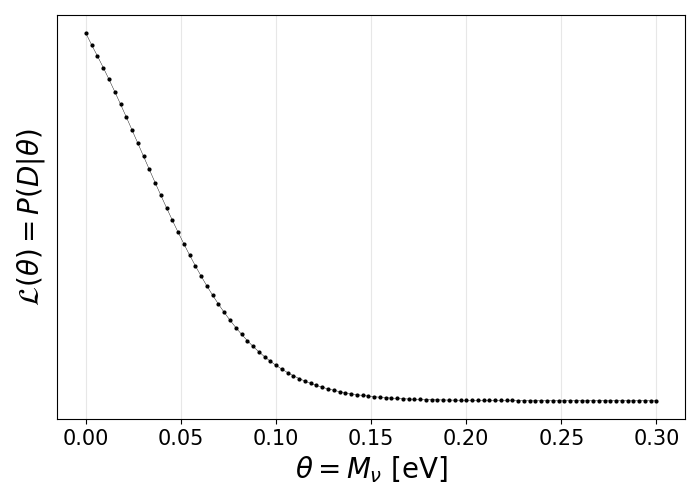

In [675]:
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(mnu,np.exp(-1./2.*chi2s_mnu),marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta =  M_\nu$ [eV]',size=20)
plt.ylabel(r"$\mathcal{L}(\theta) = P(D|\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
fig.tight_layout()
plt.savefig(current_path+"figures/lkl_mnu.pdf")

## 2D likelihood

This takes a while to compute. 
If you want to redo it, here the code:

```
%%time


np_age = 10
age = np.linspace(13.7,14.4,np_age)
np_mnu = 10
mnu = np.linspace(0.,2.,np_mnu)

lkl_age_mnu = np.zeros((len(mnu),len(age)))


for a in age:
    for b in mnu:
        i = np.where(age == a)
        j = np.where(mnu == b)
        dell_tt_th = (ls*(ls+1)/2./np.pi*compute_cls(age=a,m_nu=b)*(2.7255e6)**2)[2:5001]

        like = pyactlike.ACTPowerSpectrumData(use_tt=True,use_te=False,use_ee=False)

        lkl_age_mnu[j,i] = np.exp(like.loglike(dell_tt_th, dell_te, dell_ee, 1.0))
        
np.save('lkl_age_mnu.npy',lkl_age_mnu)
```

In [2]:
lkl_age_mnu = np.load(current_path+'/data/lkl_age_mnu_100_100.npy')

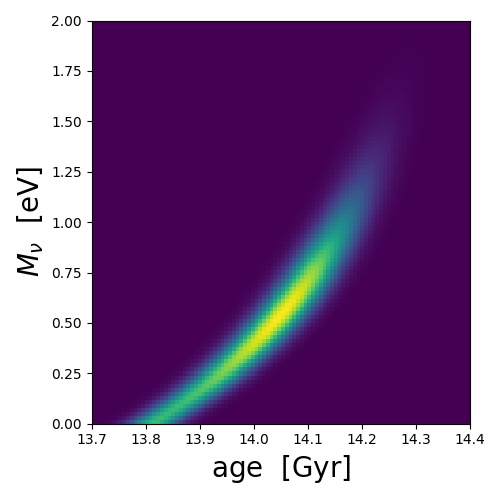

In [3]:
fig,ax = plt.subplots(figsize=(5,5))
np_age = 100
age = np.linspace(13.7,14.4,np_age)
np_mnu = 100
mnu = np.linspace(0.,2.,np_mnu)
plt.imshow(lkl_age_mnu,origin='lower',
           extent=[min(age), max(age), min(mnu), max(mnu)])
ax.set_aspect("auto")
plt.xlabel(r'$\mathrm{age}$  $\mathrm{[Gyr]}$',size=20)
plt.ylabel(r'$M_\nu$  $\mathrm{[eV]}$',size=20)
fig.tight_layout()
plt.savefig(current_path+'/figures/lkl_2d_flat.pdf')

/var/folders/h0/4_tf3pcn1h32ks9grh325v400000gn/T/ipykernel_7623/1570321051.py:18: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_lw(0.)


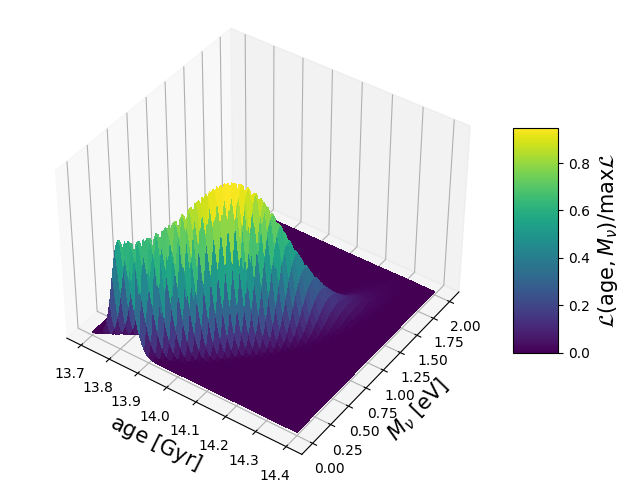

In [4]:
np_age = 100
age = np.linspace(13.7,14.4,np_age)
np_mnu = 100
mnu = np.linspace(0.,2.,np_mnu)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = age
Y = mnu
X, Y = np.meshgrid(X, Y)
Z = lkl_age_mnu/lkl_age_mnu.max()

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis,
                       linewidth=0, antialiased=False)

ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])
ax.set_xlabel(r'$\mathrm{age}$ $[\mathrm{Gyr}]$', fontsize=15, rotation=60)
ax.set_ylabel(r'$M_\nu$ $\mathrm{[eV]}$', fontsize=15, rotation=60)
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)

cbar.set_label(r"$\mathcal{L}(\mathrm{age},M_\nu)/\mathrm{max}\mathcal{L}$",size=15)

ax.view_init(elev=40, azim=-55)
fig.tight_layout()

plt.savefig(current_path+'/figures/lkl_2d.pdf')

# Simplified 1-parameter model (age)

## Prior on age uniform 

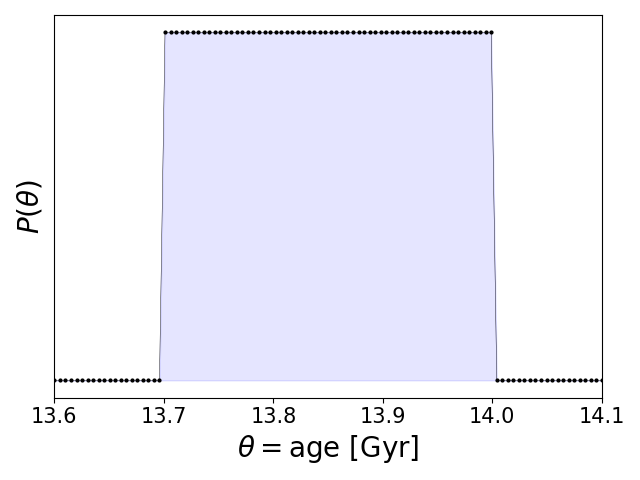

In [2]:
a = 13.7
b = 14.
u_age_x = np.linspace(a - 0.1, b + 0.1, 100)
u_age_pdf = scipy.stats.uniform.pdf(u_age_x, loc=a, scale=b-a)
fig,ax = plt.subplots()
plt.plot(u_age_x, u_age_pdf, marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$P(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.fill_between(u_age_x,u_age_pdf,color='blue',alpha=0.1)
plt.xlim(13.6,14.1)
fig.tight_layout()
plt.show()
plt.savefig(current_path+'/figures/age_prior_uniform.pdf')
plt.savefig(current_path+'/figures/age_prior_uniform.png',dpi=300)

## Likelihood of age

This takes a bit. If you want to redo it, do:
```
%%time
age = u_age_x
lkl_age = []
for a in age:
    dell_tt_th = (ls*(ls+1)/2./np.pi*compute_cls(age=a,m_nu=0.06)*(2.7255e6)**2)[2:5001]

    like = pyactlike.ACTPowerSpectrumData(use_tt=True,use_te=False,use_ee=False)

    lkl_age.append(np.exp(like.loglike(dell_tt_th, dell_te, dell_ee, 1.0)))
    # print("ACT model chi2 = " + "{0:.2f}".format(chi2)+ " for 260 data points")
lkl_age = np.asarray(lkl_age)
np.save('lkl_age.npy',lkl_age)

```

In [4]:
lkl_age = np.load(current_path+'/data/lkl_age.npy')

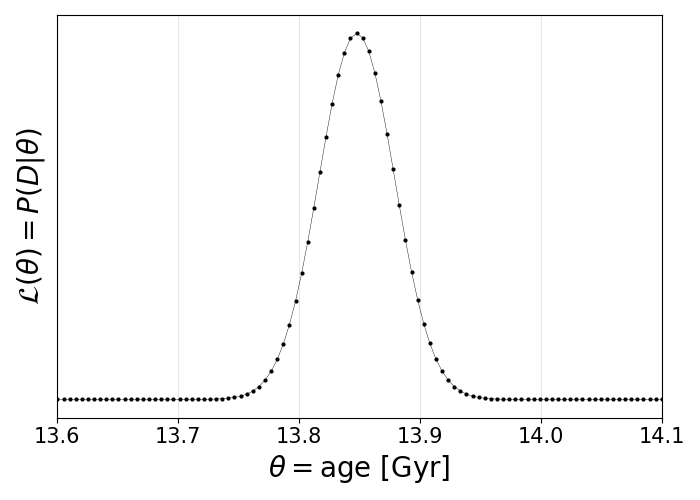

In [6]:
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(u_age_x,lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$\mathcal{L}(\theta) = P(D|\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
plt.xlim(13.6,14.1)
fig.tight_layout()
plt.savefig(current_path+"/figures/lkl_age_u.pdf")
plt.savefig(current_path+"/figures/lkl_age_u.png",dpi=300)

## Posterior on age uniform case

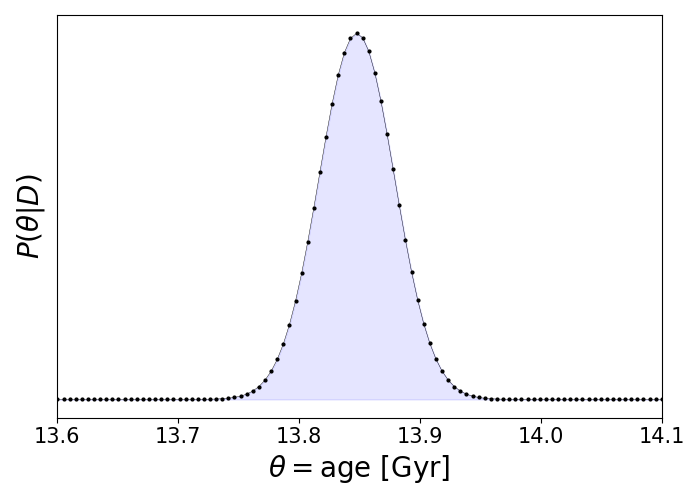

In [7]:

fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2)

plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.fill_between(u_age_x,u_age_pdf*lkl_age,color='blue',alpha=0.1)
plt.xlim(13.6,14.1)
fig.tight_layout()

plt.savefig(current_path+"/figures/posterior_age_u1.pdf")
plt.savefig(current_path+"/figures/posterior_age_u1.png",dpi=300)

## Prior on age, wide gaussian case

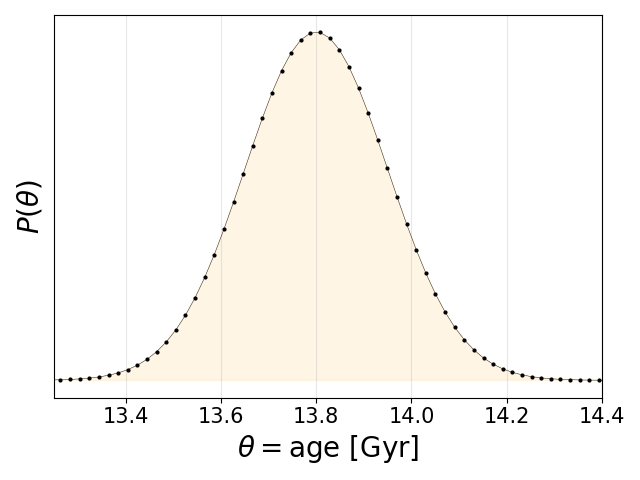

In [8]:
wide_scale = 0.15
u_age_x_wide_unzoomed = np.linspace(13,15,100)
u_age_pdf_wide_unzoomed = scipy.stats.norm.pdf(u_age_x_wide_unzoomed, loc=13.8, scale=wide_scale)
fig,ax = plt.subplots()
plt.plot(u_age_x_wide_unzoomed, u_age_pdf_wide_unzoomed, marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$P(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
plt.fill_between(u_age_x_wide_unzoomed,u_age_pdf_wide_unzoomed,color='orange',alpha=0.1)
plt.xlim(13.25,14.4)
fig.tight_layout()

plt.show()
plt.savefig(current_path+"/figures/posterior_age_u2_gaussian.pdf")
plt.savefig(current_path+"/figures/posterior_age_u2_gaussian.png",dpi=300)

## Compare uniform and wide gaussian

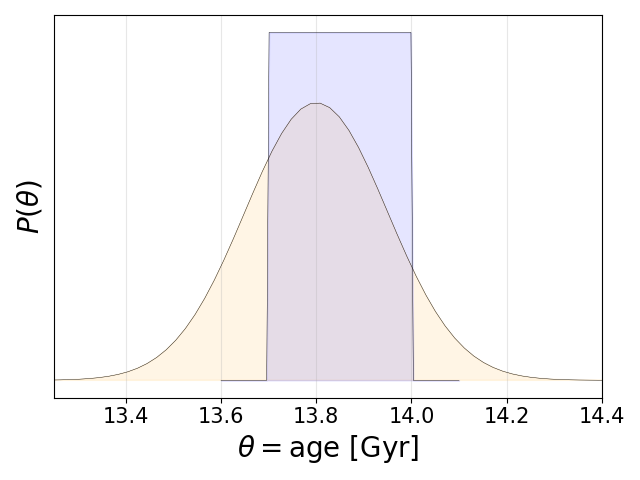

In [9]:
wide_scale = 0.15
u_age_x_wide_unzoomed = np.linspace(13,15,100)
u_age_pdf_wide_unzoomed = scipy.stats.norm.pdf(u_age_x_wide_unzoomed, loc=13.8, scale=wide_scale)
fig,ax = plt.subplots()
plt.plot(u_age_x_wide_unzoomed, u_age_pdf_wide_unzoomed, marker='o',c='k',ls='-',lw=0.3,markersize= 0)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$P(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
plt.fill_between(u_age_x_wide_unzoomed,u_age_pdf_wide_unzoomed,color='orange',alpha=0.1)


a = 13.7
b = 14.
u_age_x = np.linspace(a - 0.1, b + 0.1, 100)
u_age_pdf = scipy.stats.uniform.pdf(u_age_x, loc=a, scale=b-a)
plt.plot(u_age_x, u_age_pdf, marker='o',c='k',ls='-',lw=0.3,markersize= 0) 

plt.fill_between(u_age_x,u_age_pdf,color='blue',alpha=0.1)


plt.xlim(13.25,14.4)
fig.tight_layout()

plt.show()
plt.savefig(current_path+"/figures/posterior_age_u2_gaussian_vs_uni.pdf")
plt.savefig(current_path+"/figures/posterior_age_u2_gaussian_vs_uni.png",dpi=300)

## Zoom wide gaussian on region of interest

0.15


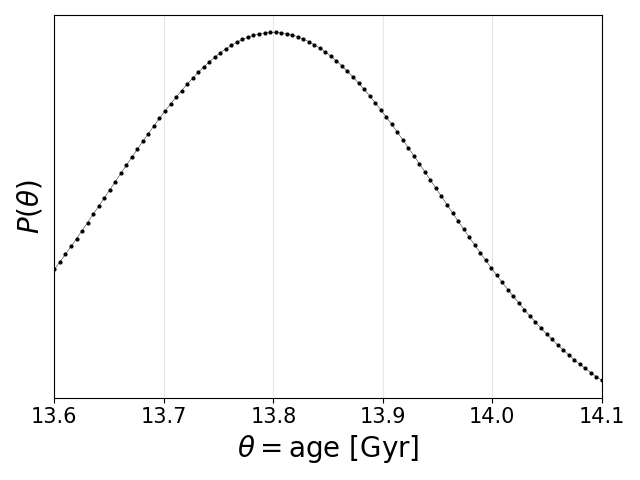

In [10]:
u_age_pdf_wide = scipy.stats.norm.pdf(u_age_x, loc=13.8, scale=wide_scale)
print(wide_scale)
fig,ax = plt.subplots()

plt.plot(u_age_x, u_age_pdf_wide, marker='o',c='k',ls='-',lw=0.3,markersize= 2)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
plt.ylabel(r"$P(\theta)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.grid(which='both',alpha=0.3)
plt.xlim(13.6,14.1)
fig.tight_layout()

plt.show()


## Posterior on age wide gaussian case

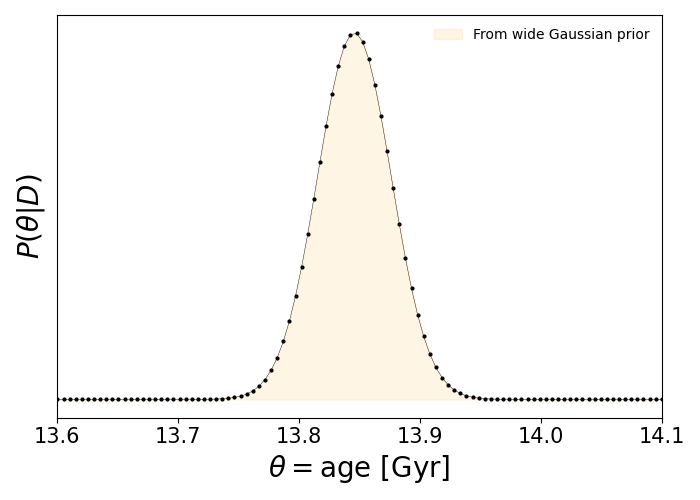

In [11]:

fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(u_age_x,u_age_pdf_wide*lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2)

plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  

plt.xlim(13.6,14.1)
plt.fill_between(u_age_x,u_age_pdf_wide*lkl_age,color='orange',alpha=0.1,label='From wide Gaussian prior')
plt.legend(frameon=False)
fig.tight_layout()

plt.savefig(current_path+"/figures/posterior_age_wg.pdf")
plt.savefig(current_path+"/figures/posterior_age_wg.png",dpi=300)

## Simple KDE to find the credible intervals

In [12]:
from scipy.optimize import curve_fit
# Define the Gaussian (normal) distribution function
def gaussian(x,  amplitude, mean, stddev):
    return amplitude/(np.sqrt(2.*np.pi*stddev**2)) * np.exp(-((x - mean) / stddev) ** 2 / 2)

fit_params, covariance = curve_fit(gaussian, u_age_x, u_age_pdf*lkl_age, p0=[1e-23, 15.,2.])



In [13]:
fit_params

array([1.13847510e-22, 1.38476430e+01, 3.12302211e-02])

In [14]:
y_fit = gaussian(u_age_x, *fit_params)

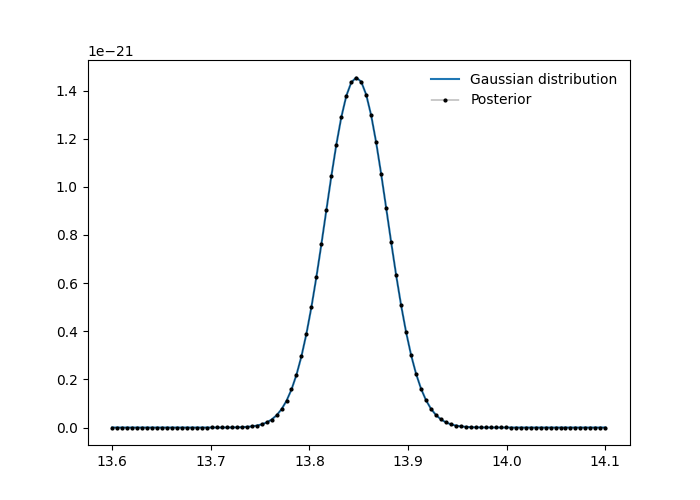

In [15]:
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(u_age_x,y_fit,label='Gaussian distribution')
plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2.,label='Posterior')
plt.legend(frameon=False)
plt.show()

In [18]:
gaussian_pdf = scipy.stats.norm.pdf(u_age_x, loc=fit_params[1], scale=np.abs(fit_params[2]))

In [19]:
sigma_1_interval = fit_params[1] + np.array([-1, 1]) * np.abs(fit_params[2])
sigma_1_interval

array([13.81641274, 13.87887319])

In [20]:
sigma_2_interval = fit_params[1] + np.array([-2, 2]) * np.abs(fit_params[2])
sigma_2_interval

array([13.78518252, 13.91010341])

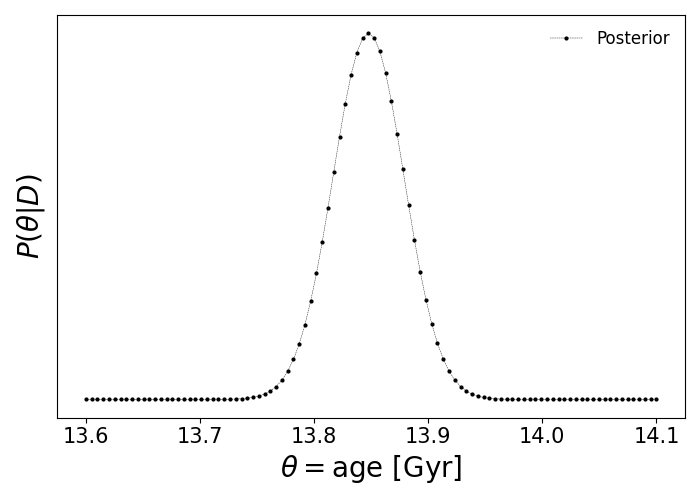

In [23]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()
plt.show()
plt.savefig(current_path+'/figures/posterior_only_age.png',dpi=300)
plt.savefig(current_path+'/figures/posterior_only_age.pdf')


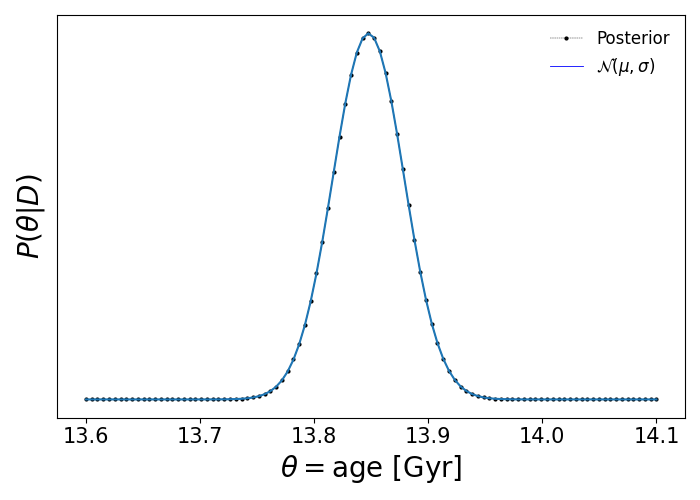

In [24]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')
plt.plot(u_age_x,y_fit,label=r'$\mathcal{N}(\mu,\sigma)$',c='b',lw=0.6)


plt.plot(u_age_x,gaussian_pdf*fit_params[0])
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()

plt.savefig(current_path+'/figures/posterior_only_age_plus_gauss.png',dpi=300)
plt.savefig(current_path+'/figures/posterior_only_age_plus_gauss.pdf')


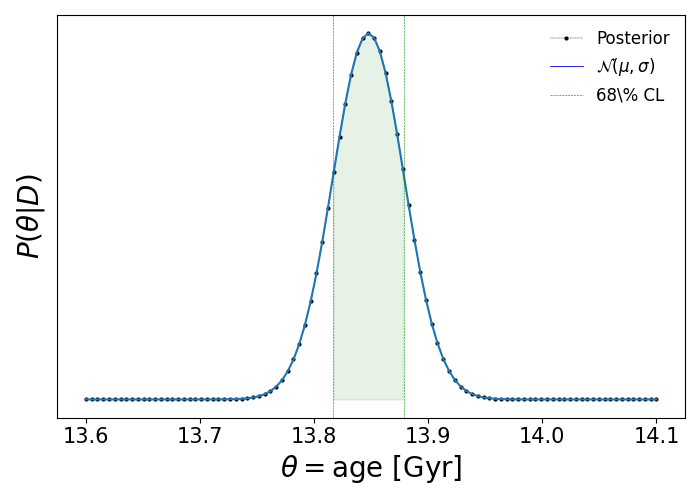

In [25]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')
plt.plot(u_age_x,y_fit,label=r'$\mathcal{N}(\mu,\sigma)$',c='b',lw=0.6)


plt.plot(u_age_x,gaussian_pdf*fit_params[0])

plt.axvline(sigma_1_interval[0],ymin = 0,ymax = 1, color='green',  linestyle='--',lw=0.4, label='68\% CL')
plt.axvline(sigma_1_interval[1],ymin = 0,ymax = 1, color='green', linestyle='--',lw=0.4)

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],
                 fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],color='green',alpha=0.1)
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()

plt.savefig(current_path+'/figures/posterior_only_age_plus_gauss_1s.png',dpi=300)
plt.savefig(current_path+'/figures/posterior_only_age_plus_gauss_1s.pdf')


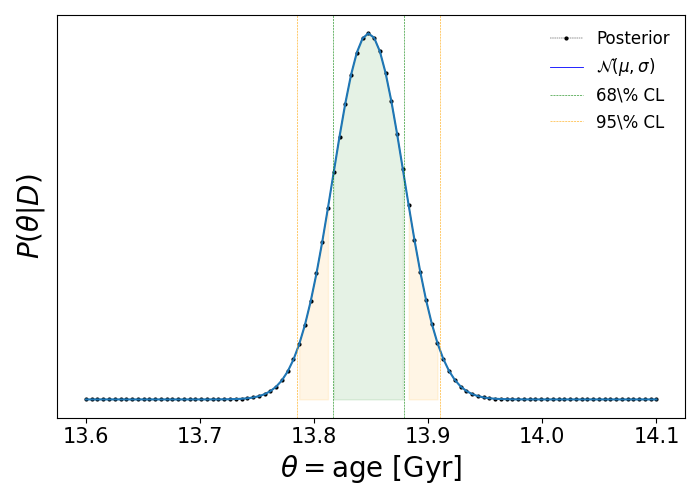

In [26]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,u_age_pdf*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')
plt.plot(u_age_x,y_fit,label=r'$\mathcal{N}(\mu,\sigma)$',c='b',lw=0.6)


plt.plot(u_age_x,gaussian_pdf*fit_params[0])
# Plot confidence intervals


plt.axvline(sigma_1_interval[0],ymin = 0,ymax = 1, color='green',  linestyle='--',lw=0.4, label='68\% CL')
plt.axvline(sigma_1_interval[1],ymin = 0,ymax = 1, color='green', linestyle='--',lw=0.4)

plt.axvline(sigma_2_interval[0], ymax = 1., color='orange',lw=0.4, linestyle='--', label='95\% CL')
plt.axvline(sigma_2_interval[1], ymax = 1., color='orange',lw=0.4, linestyle='--')

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],
                 fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[0]) & (u_age_x<sigma_1_interval[1])],color='green',alpha=0.1)

plt.fill_between(u_age_x[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],
                 fit_params[0]*gaussian_pdf[(u_age_x<sigma_1_interval[0]) & (u_age_x>sigma_2_interval[0])],color='orange',alpha=0.1)

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],
                 fit_params[0]*gaussian_pdf[(u_age_x>sigma_1_interval[1]) & (u_age_x<sigma_2_interval[1])],color='orange',alpha=0.1)

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()

plt.savefig(current_path+'/figures/posterior_only_age_plus_gauss_1s_2s.png',dpi=300)
plt.savefig(current_path+'/figures/posterior_only_age_plus_gauss_1s_2s.pdf')


Wide Gaussian prior

In [30]:
from scipy.optimize import curve_fit
# Define the Gaussian (normal) distribution function
def gaussian(x,  amplitude, mean, stddev):
    return amplitude/(np.sqrt(2.*np.pi*stddev**2)) * np.exp(-((x - mean) / stddev) ** 2 / 2)

fit_params_wide, covariance = curve_fit(gaussian, u_age_x, u_age_pdf_wide*lkl_age, p0=[1e-23, 15.,2.])



In [31]:
fit_params_wide

array([8.47392286e-23, 1.38456648e+01, 3.05792254e-02])

In [32]:
y_fit = gaussian(u_age_x, *fit_params_wide)

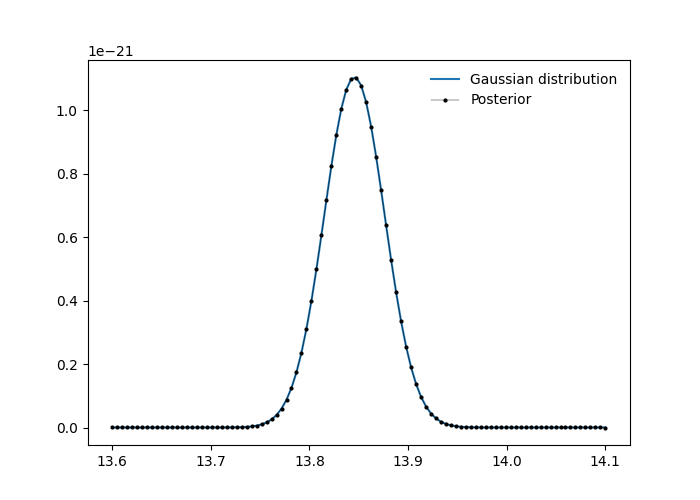

In [33]:
fig, ax  = plt.subplots(figsize=(7,5))
plt.plot(u_age_x,y_fit,label='Gaussian distribution')
plt.plot(u_age_x,u_age_pdf_wide*lkl_age,marker='o',c='k',ls='-',lw=0.3,markersize= 2.,label='Posterior')
plt.legend(frameon=False)
plt.show()

In [36]:
gaussian_pdf_wide = scipy.stats.norm.pdf(u_age_x, loc=fit_params_wide[1], scale=np.abs(fit_params_wide[2]))

In [37]:
sigma_1_interval_wide = fit_params_wide[1] + np.array([-1, 1]) * np.abs(fit_params_wide[2])
sigma_1_interval_wide

array([13.8150856 , 13.87624405])

In [38]:
sigma_2_interval_wide = fit_params_wide[1] + np.array([-2, 2]) * np.abs(fit_params_wide[2])
sigma_2_interval_wide

array([13.78450637, 13.90682327])

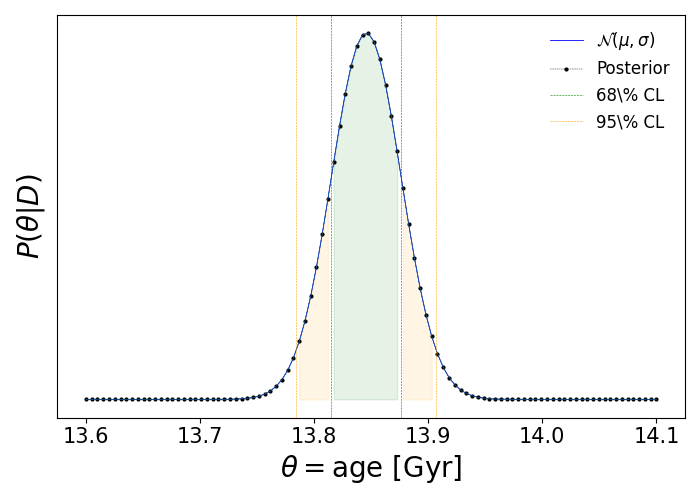

In [39]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,y_fit,label=r'$\mathcal{N}(\mu,\sigma)$',c='b',lw=0.6)
plt.plot(u_age_x,u_age_pdf_wide*lkl_age,marker='o',c='k',ls='--',lw=0.3,markersize= 2.,label='Posterior')

plt.plot(u_age_x,gaussian_pdf_wide*fit_params_wide[0],lw=0.4)



plt.axvline(sigma_1_interval_wide[0],ymin = 0,ymax = 1, color='green',  linestyle='--',lw=0.4, label='68\% CL')
plt.axvline(sigma_1_interval_wide[1],ymin = 0,ymax = 1, color='green', linestyle='--',lw=0.4)

plt.axvline(sigma_2_interval_wide[0], ymax = 1., color='orange',lw=0.4, linestyle='--', label='95\% CL')
plt.axvline(sigma_2_interval_wide[1], ymax = 1., color='orange',lw=0.4, linestyle='--')

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval_wide[0]) & (u_age_x<sigma_1_interval_wide[1])],
                 fit_params_wide[0]*gaussian_pdf_wide[(u_age_x>sigma_1_interval_wide[0]) & (u_age_x<sigma_1_interval_wide[1])],color='green',alpha=0.1)

plt.fill_between(u_age_x[(u_age_x<sigma_1_interval_wide[0]) & (u_age_x>sigma_2_interval_wide[0])],
                 fit_params_wide[0]*gaussian_pdf_wide[(u_age_x<sigma_1_interval_wide[0]) & (u_age_x>sigma_2_interval_wide[0])],color='orange',alpha=0.1)

plt.fill_between(u_age_x[(u_age_x>sigma_1_interval_wide[1]) & (u_age_x<sigma_2_interval_wide[1])],
                 fit_params_wide[0]*gaussian_pdf_wide[(u_age_x>sigma_1_interval_wide[1]) & (u_age_x<sigma_2_interval_wide[1])],color='orange',alpha=0.1)

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  

plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()
plt.show()


Analytical estimate


We can compute the mean and standard deviation of the posterior analytically in this case:





In [40]:
m1 = fit_params[1]
m2 = 13.8
s1 = fit_params[2]
s2 = wide_scale
mu = (m1/s1**2 + m2/s2**2)/(1./s1**2+1./s2**2)
s = 1./np.sqrt(1./s1**2+1./s2**2) 

In [41]:
mu

13.845663547514786

In [42]:
s

0.030574579688777272

In [43]:
fit_params_wide[2]

0.03057922537986788

In [44]:
fit_params_wide[1]

13.845664821098824

In [45]:
m1

13.84764296429599

In [46]:
s1

0.03123022110514296

In [48]:
gaussian_pdf_analytical = scipy.stats.norm.pdf(u_age_x, loc=mu, scale=s)

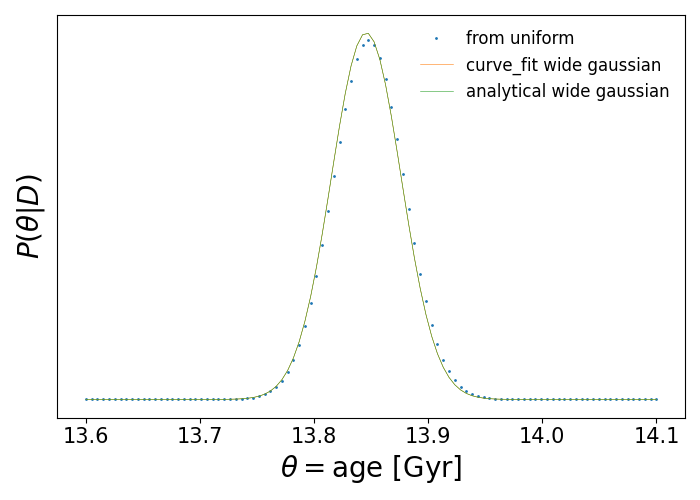

In [49]:
fig, ax  = plt.subplots(figsize=(7,5))

plt.plot(u_age_x,gaussian_pdf,lw=0.4,label='from uniform',marker='o',markersize=1.,ls='None')
plt.plot(u_age_x,gaussian_pdf_wide,lw=0.4,label='curve_fit wide gaussian')
plt.plot(u_age_x,gaussian_pdf_analytical,lw=0.4,label='analytical wide gaussian')
plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  
plt.legend(frameon=False,fontsize = 12)
plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)
fig.tight_layout()
plt.show()


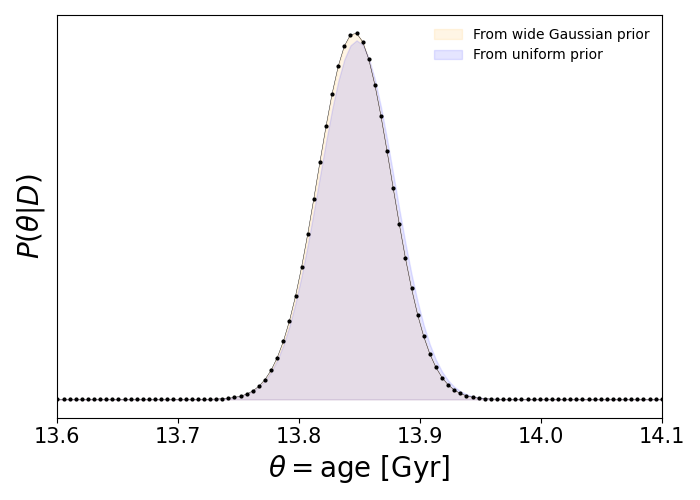

In [50]:

fig, ax  = plt.subplots(figsize=(7,5))


plt.plot(u_age_x,u_age_pdf_wide*lkl_age/fit_params_wide[0],marker='o',c='k',ls='-',lw=0.3,markersize= 2)

plt.xlabel(r'$\theta = \mathrm{age}\,\,\mathrm{[Gyr]}$',size=20)

plt.ylabel(r"$P(\theta|D)$",size=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([])  

plt.xlim(13.6,14.1)
plt.fill_between(u_age_x,u_age_pdf_wide*lkl_age/fit_params_wide[0],color='orange',alpha=0.1,label='From wide Gaussian prior')

plt.fill_between(u_age_x,u_age_pdf*lkl_age/fit_params[0],color='blue',alpha=0.1,label='From uniform prior')

plt.legend(frameon=False)
fig.tight_layout()

plt.savefig(current_path+"/figures/posterior_age_wg_compare.pdf")
plt.savefig(current_path+"/figures/posterior_age_wg_compare.png",dpi=300)

This concludes all the material presented in the slides.